In [497]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from math import gcd
import numpy as np
from IPython.display import display
%matplotlib inline

# Quantum Shor's Algorithm

In [498]:
N = 15 # number to factorize
n = np.ceil(np.log2(N)).astype(int) # number of bits to represent N
q = QuantumRegister(2*n, "q") # input qubits
t = QuantumRegister(n, "t") # target qubits
c = ClassicalRegister(2*n, "c") # classical bits

In [499]:
a = np.random.randint(2, N) # number possibly coprime with N
while gcd(a, N) > 1:
    a = np.random.randint(2, N)
print(f"Chosen base a = {a}")

Chosen base a = 13


Uf is a unitary transformation that compute the modular exponentiation of a number 'a' raised to the power of 2^i mod N, with i ranging from 0 to 2n-1. The unitary transformation is defined as:

In [500]:
def Uf(circ):
    for i in range(2*n):
        mod_exp = pow(a, 2**i, N)
        circ.cp(2*np.pi*mod_exp/N, q[i], t)

#### Quantum order-finding procedure:

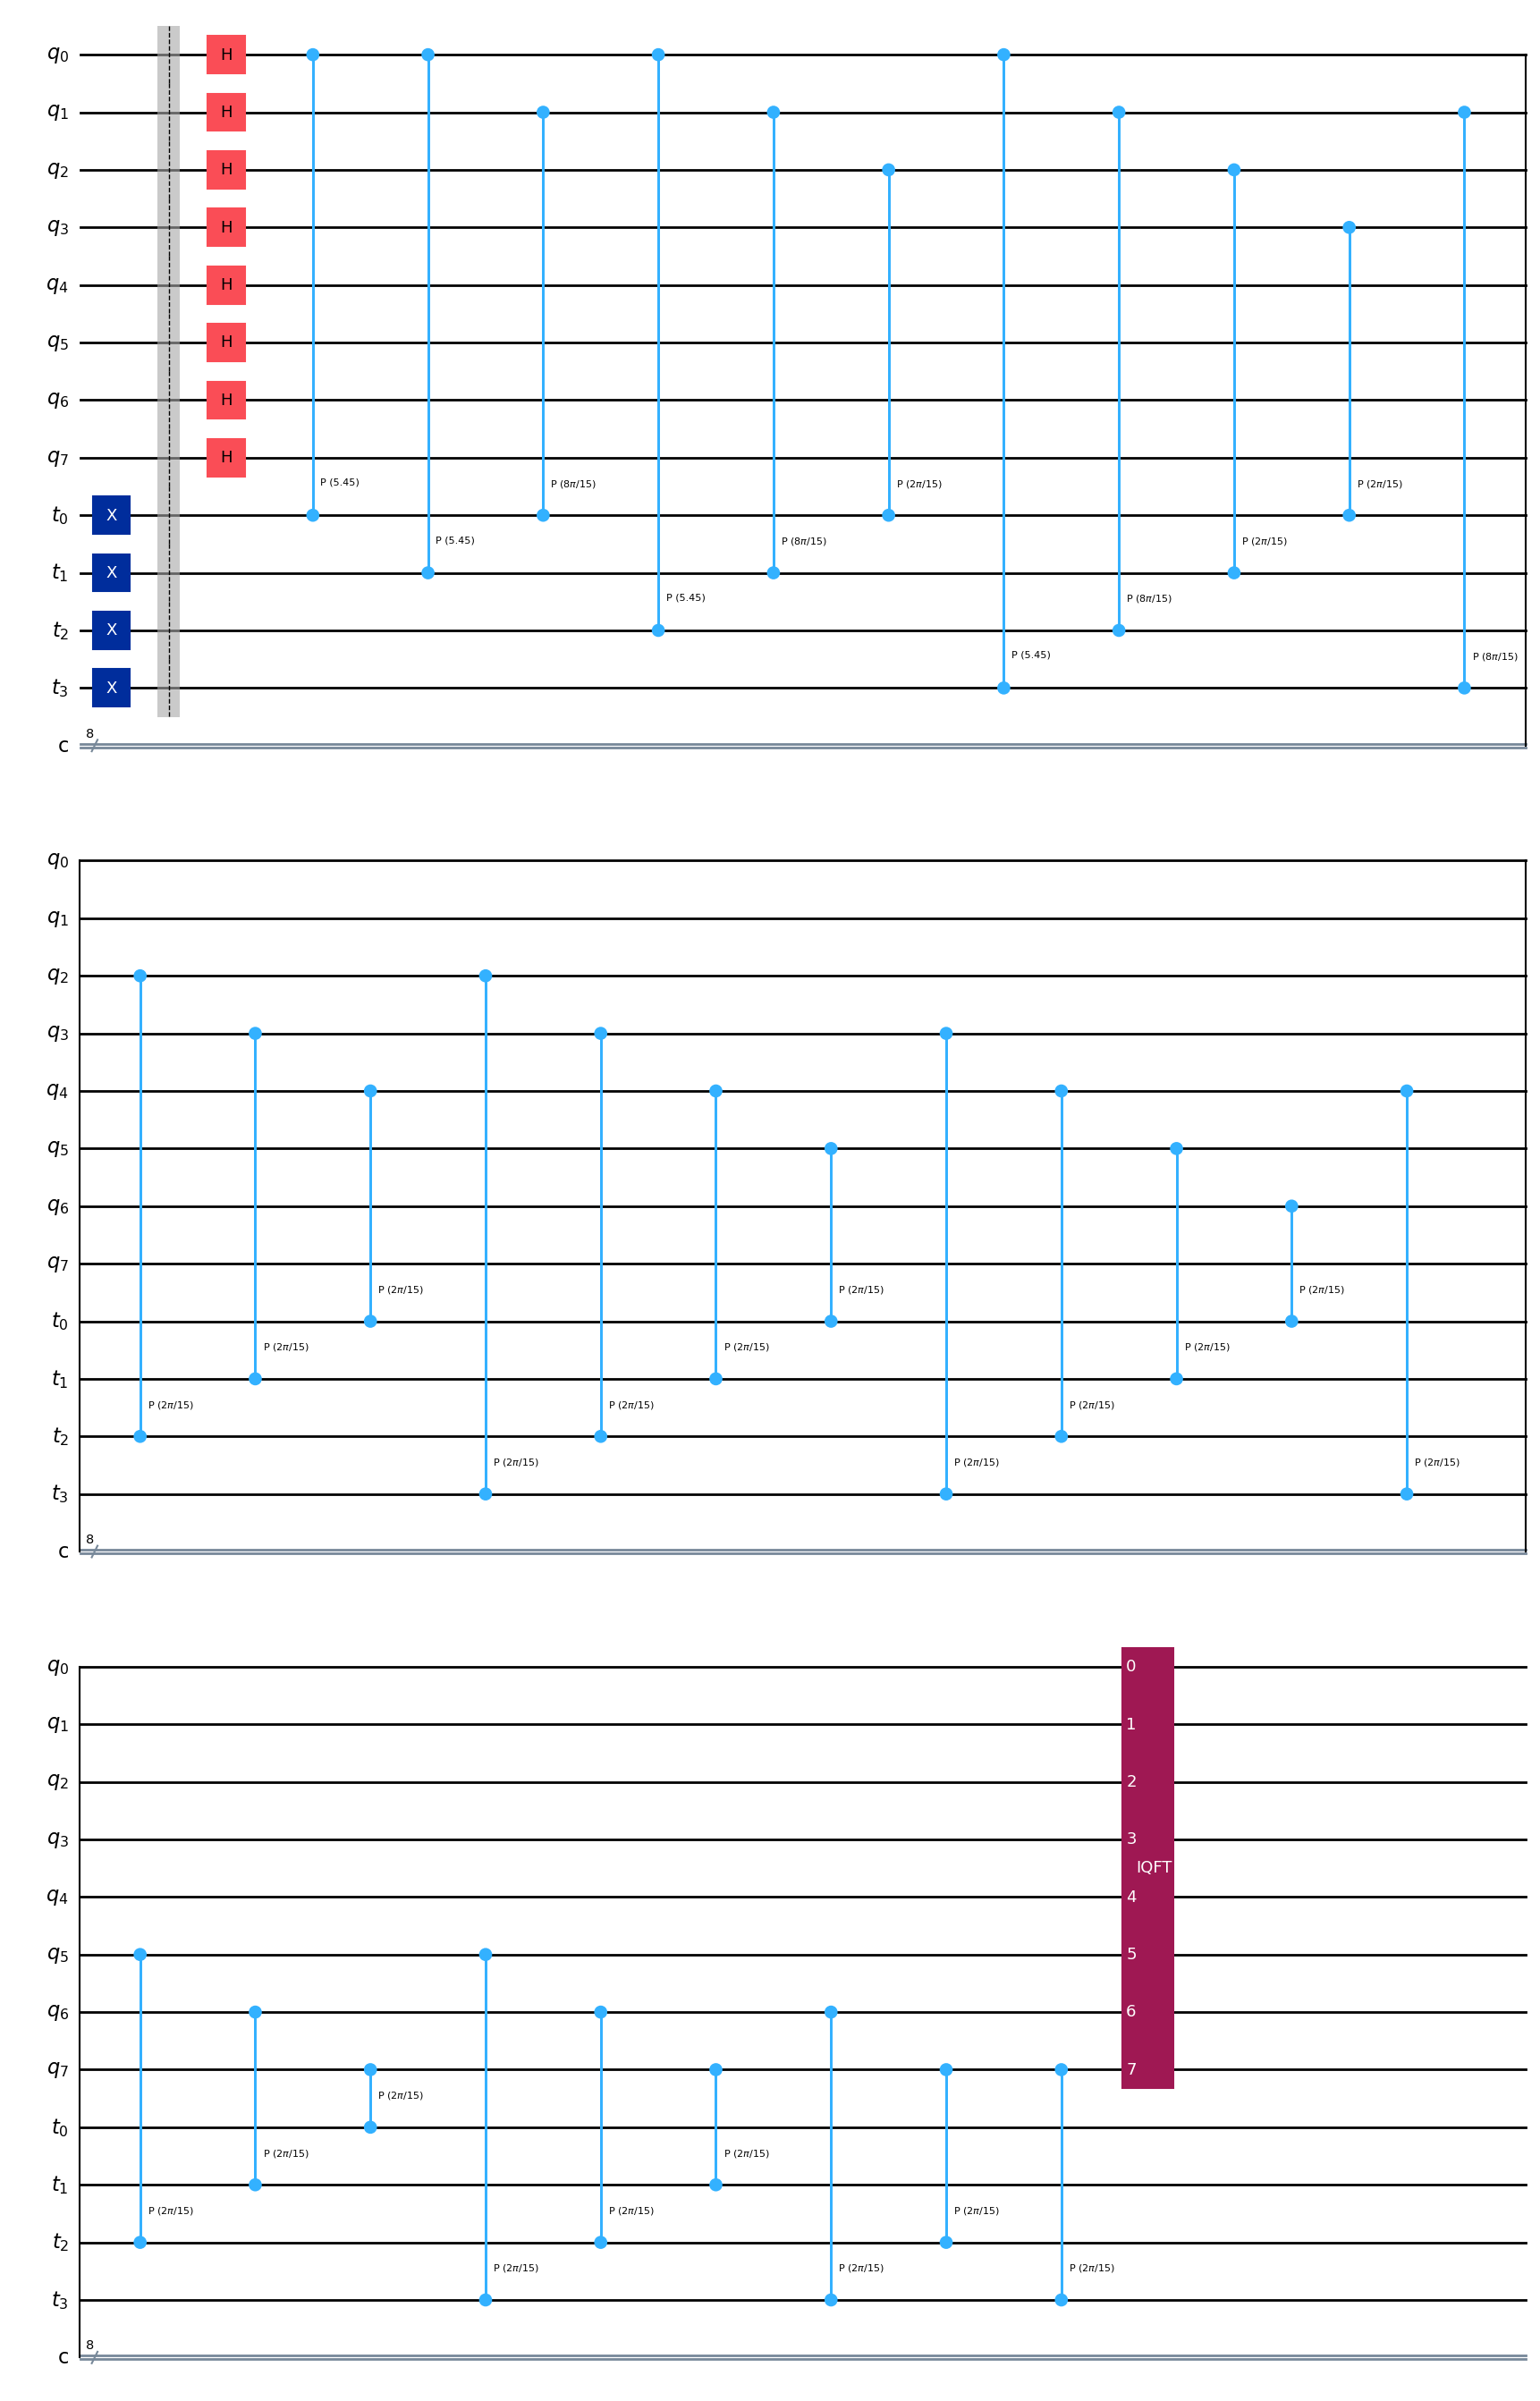

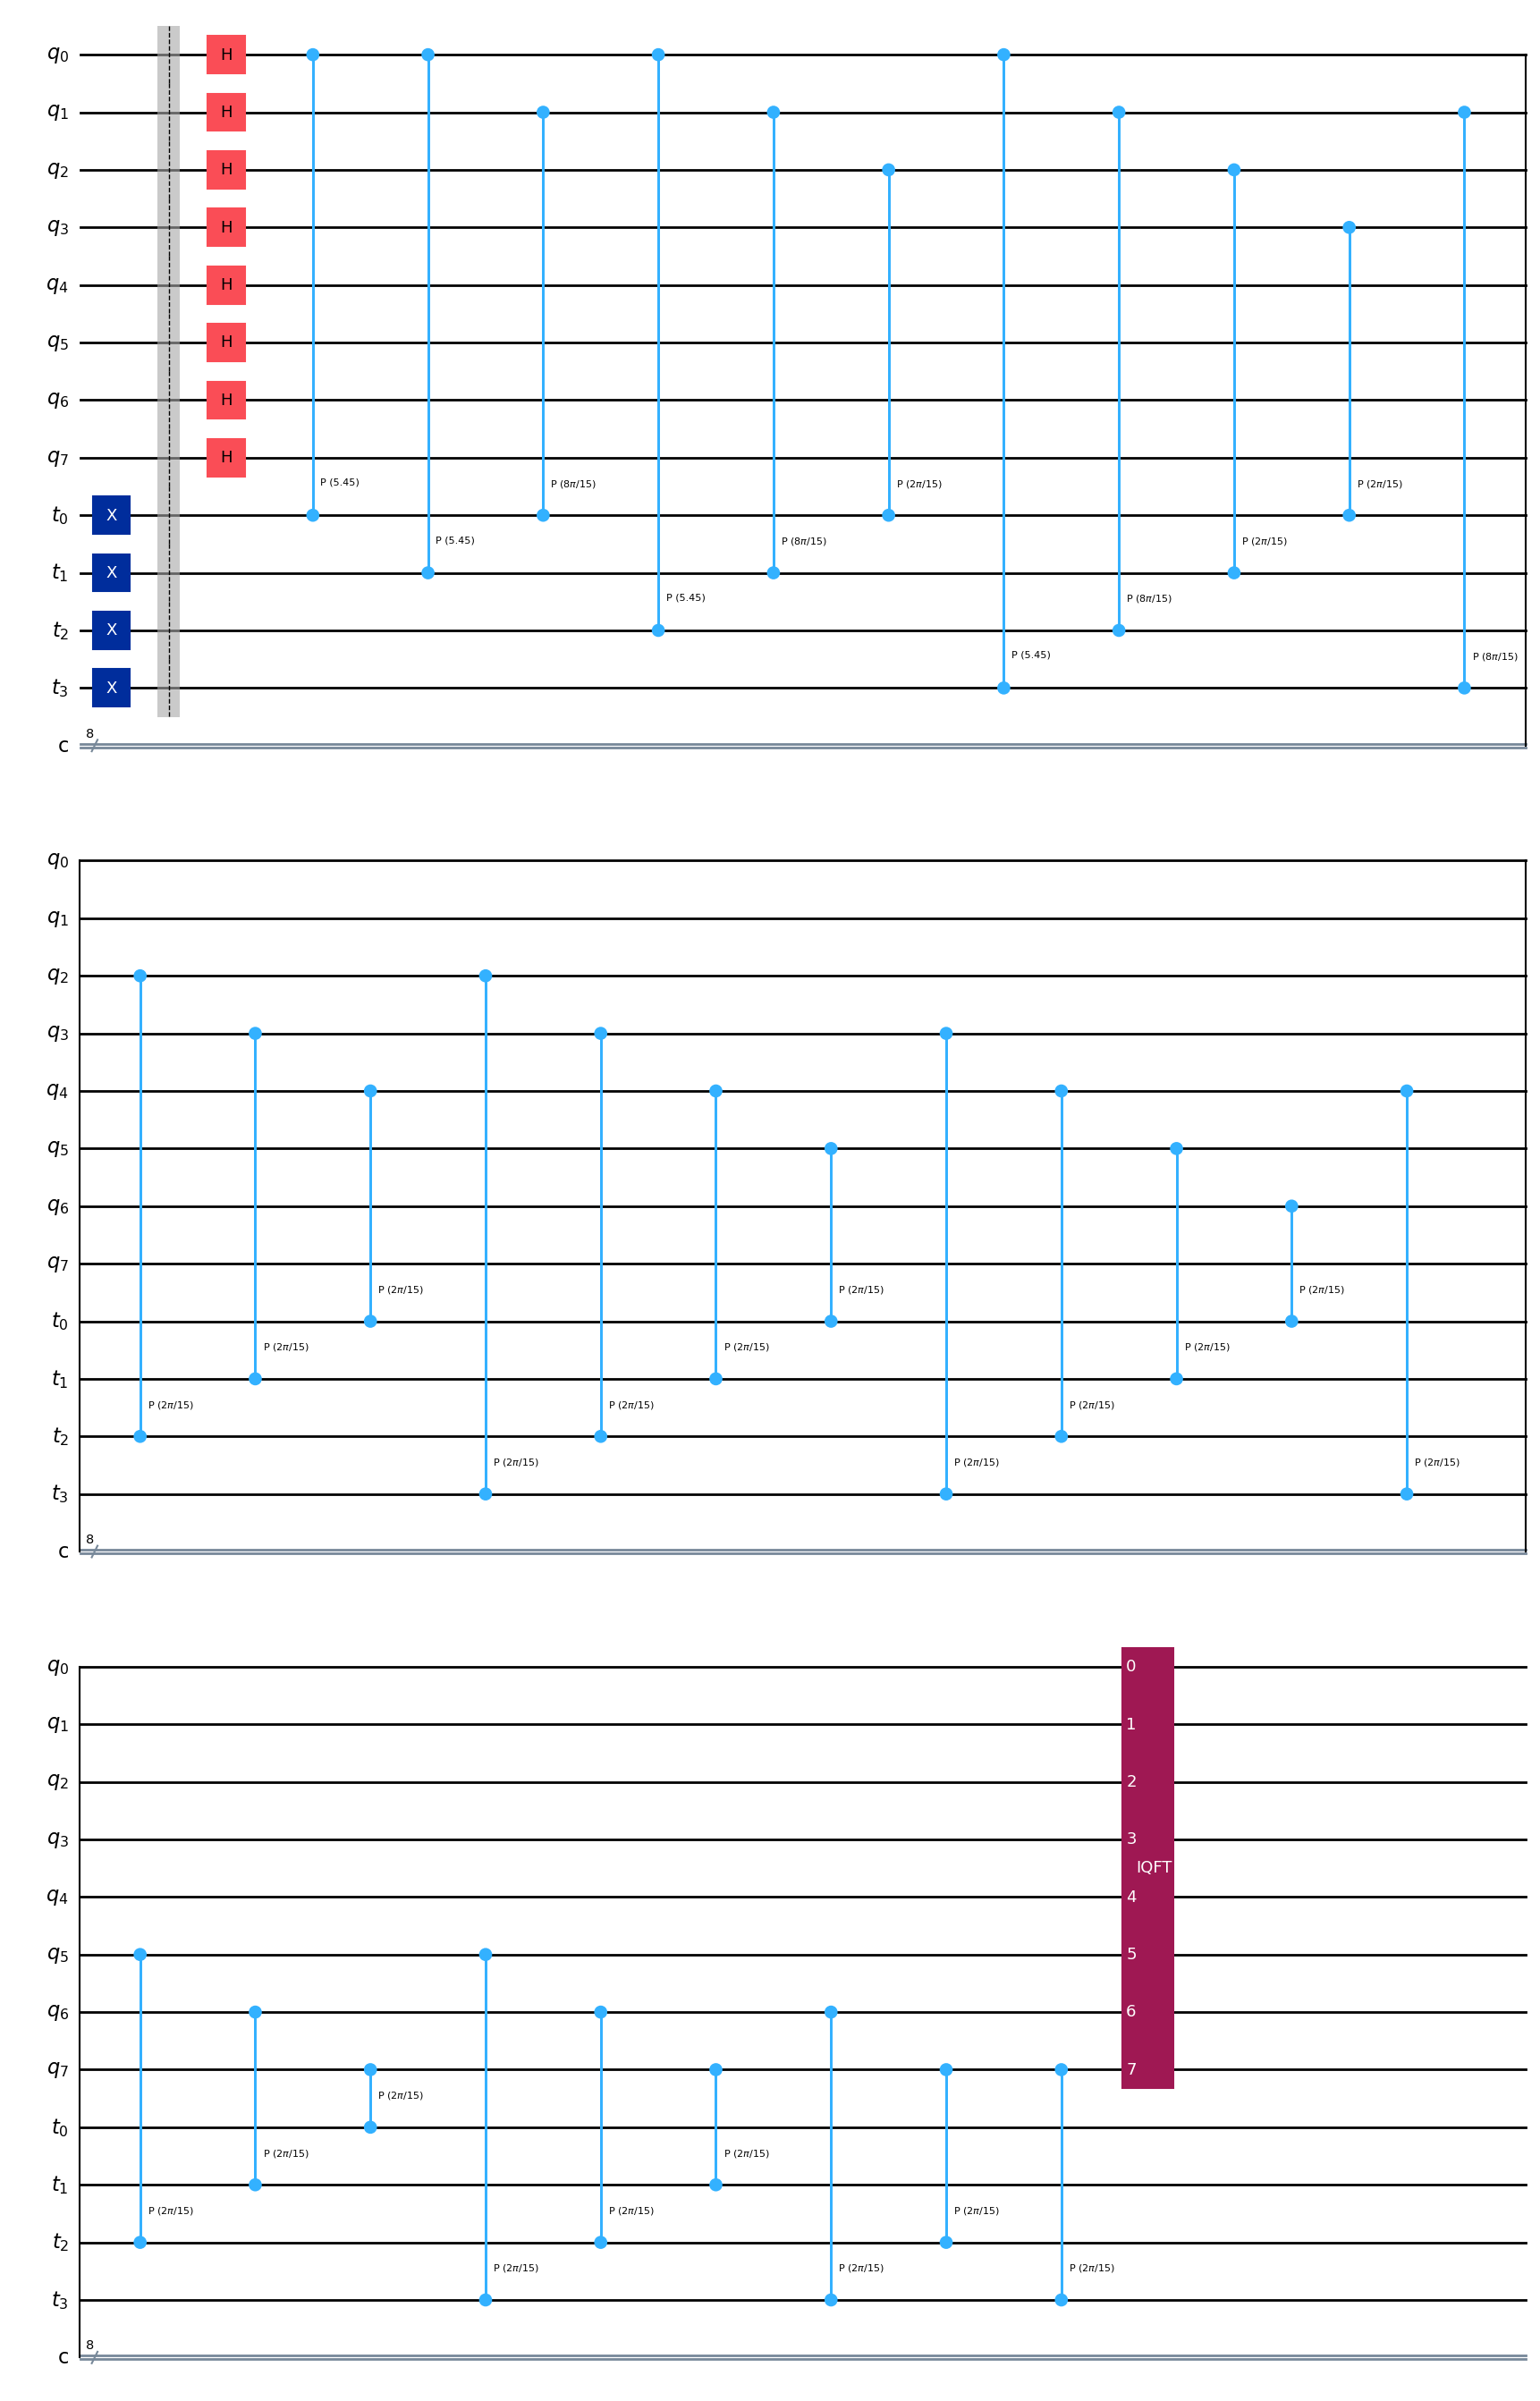

In [501]:
qpe = QuantumCircuit(q, t, c, name="quantum phase estimation")
qpe.x(t) # initialize the target qubits to |1>
qpe.barrier()
qpe.h(q) # apply H-gate to all input qubits
Uf(qpe) # apply modular exponentiation
qpe.append(QFT(2*n, inverse=True), q) # apply the inverse QFT
qpe.draw("mpl")

In [502]:
state = Statevector.from_instruction(qpe)
state.draw("latex")

<IPython.core.display.Latex object>

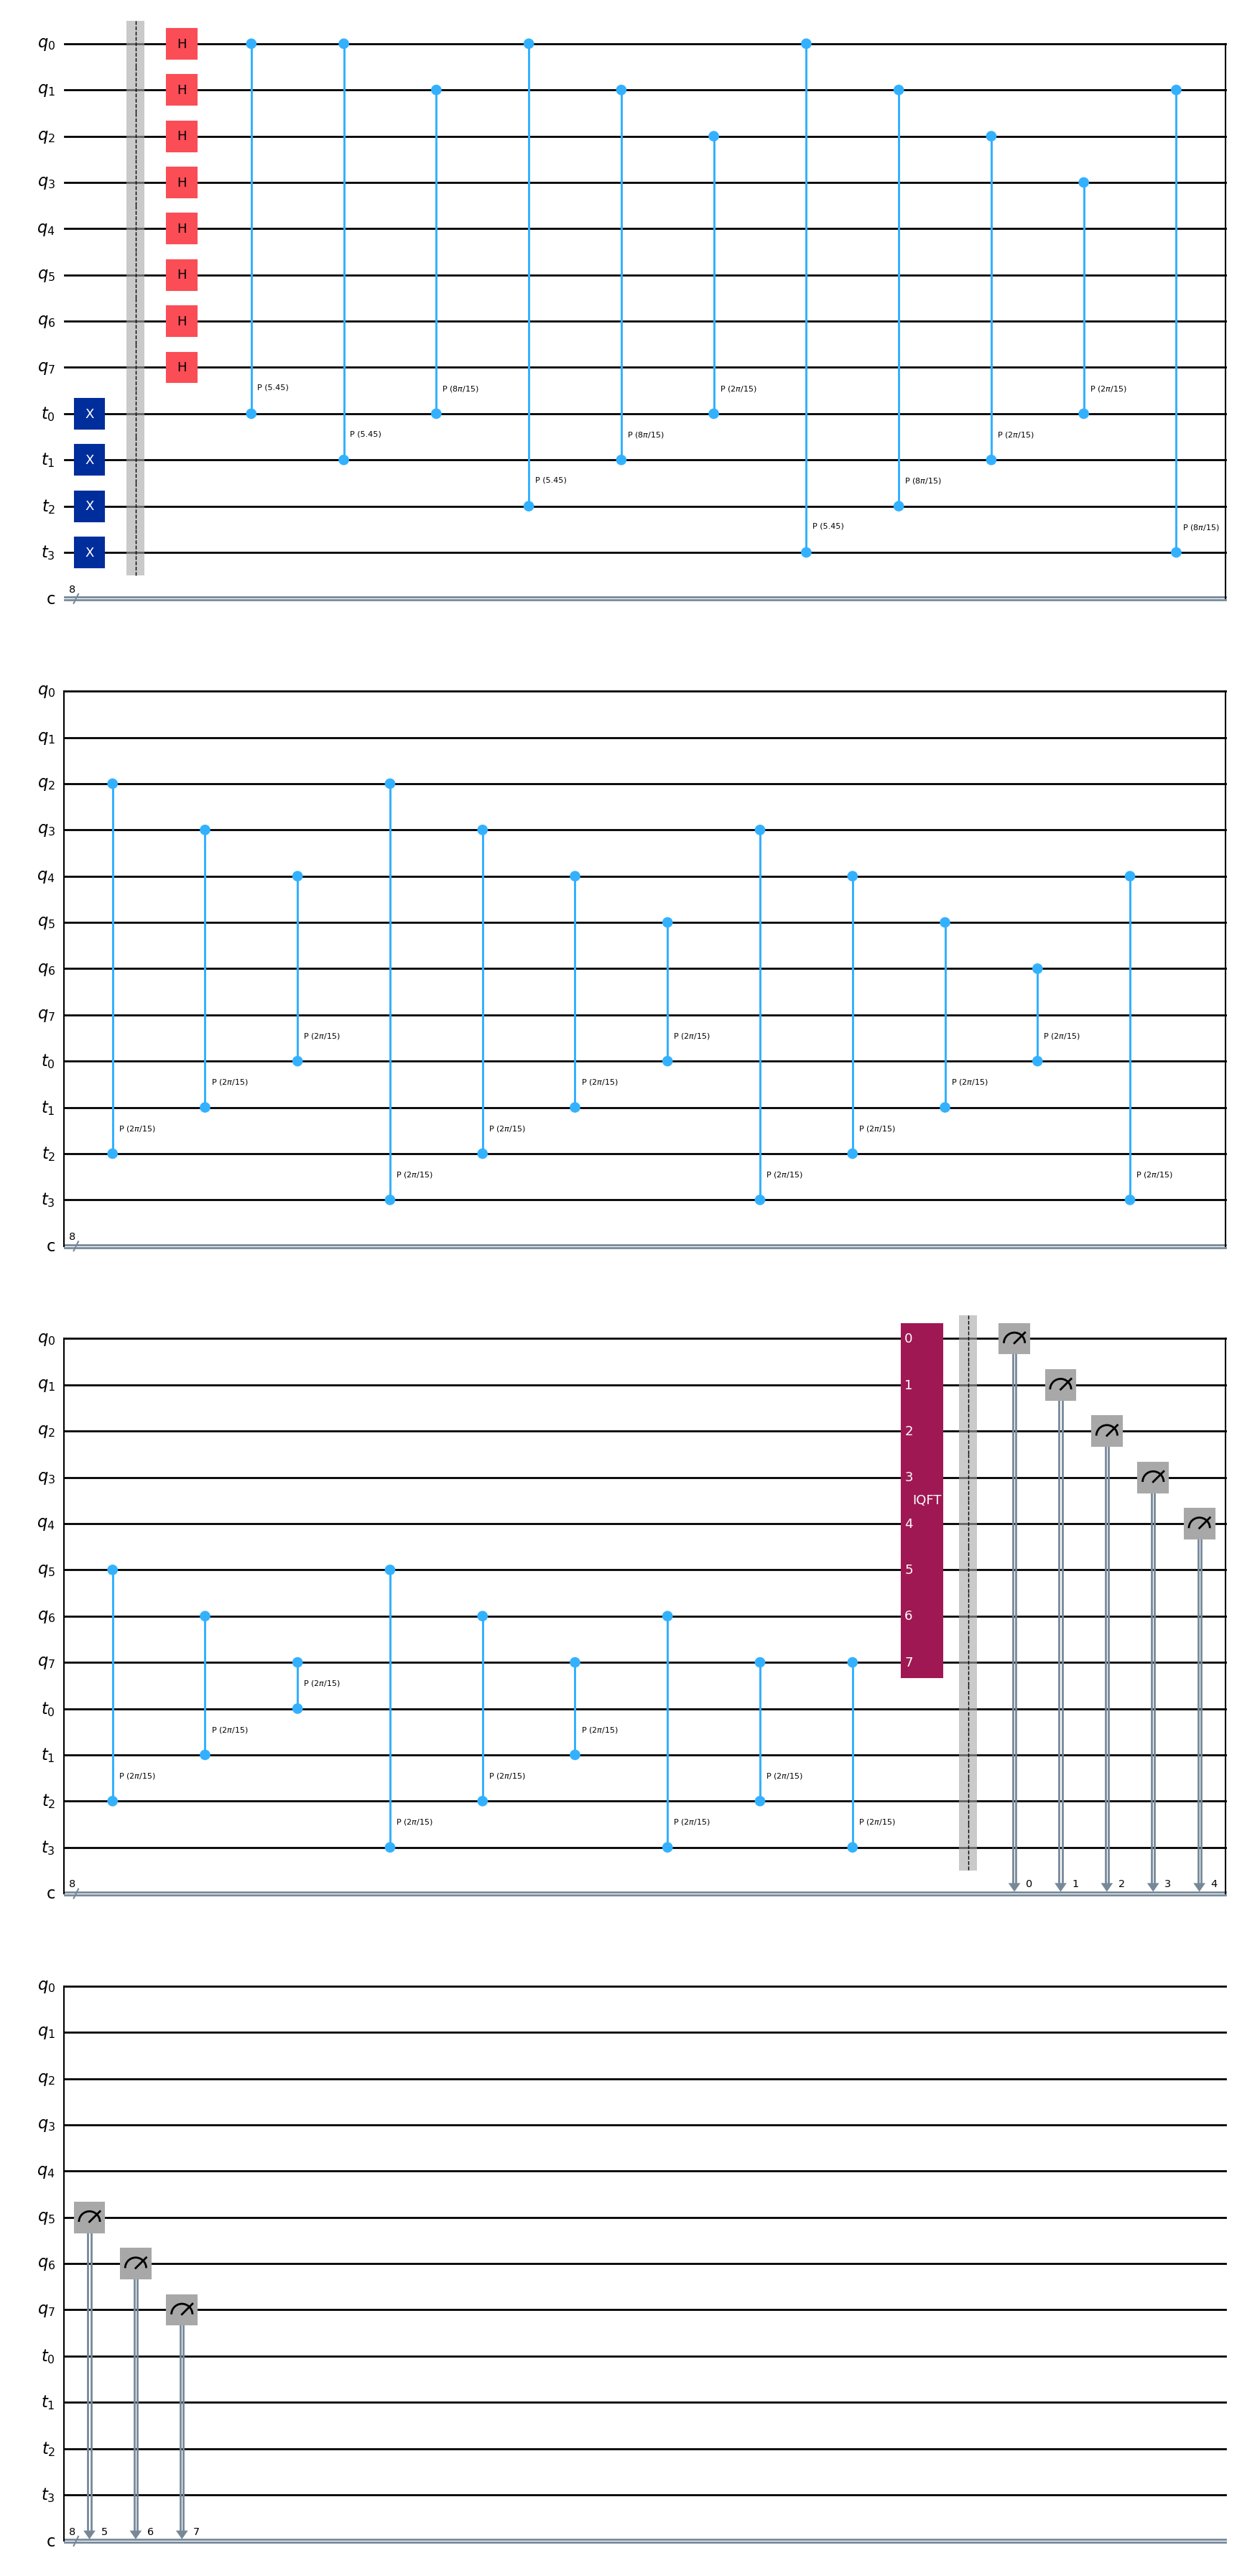

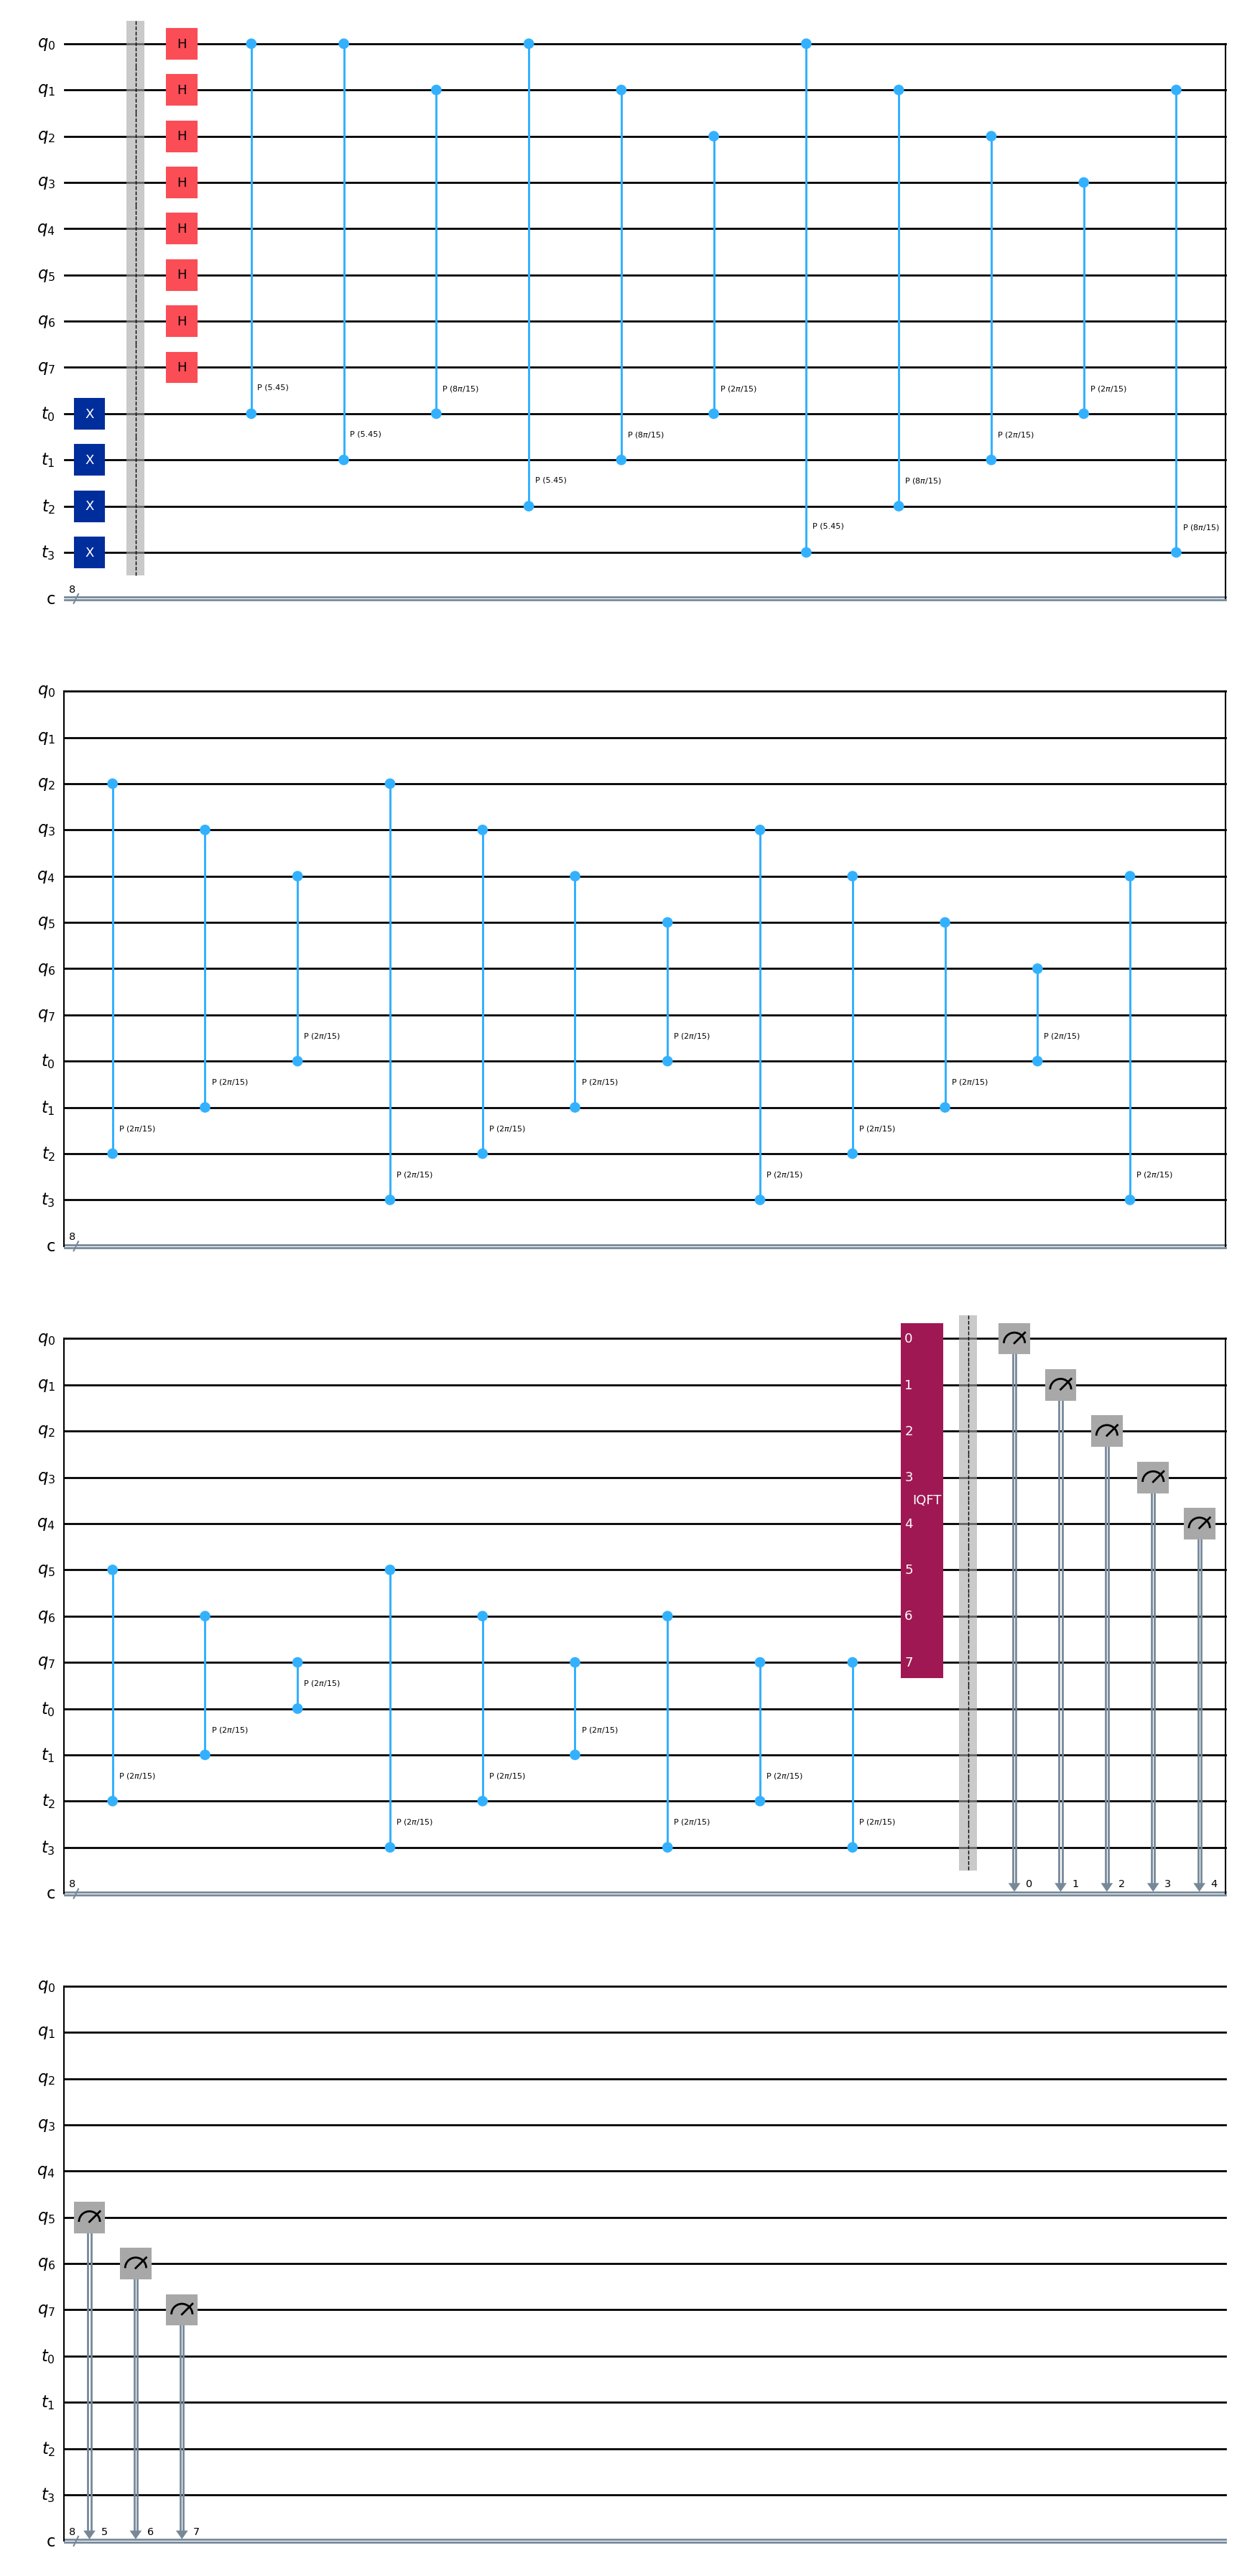

In [503]:
qpe.barrier()
qpe.measure(q, c)
qpe.draw("mpl")

In [504]:
backend = Aer.get_backend('qasm_simulator')
compiled = transpile(qpe, backend)
result = backend.run(compiled, shots=1024).result()
counts = result.get_counts()
print(counts)

{'00101101': 1, '10101000': 2, '10010000': 20, '10000100': 55, '01010001': 4, '10010010': 73, '00001000': 2, '11000001': 2, '10010001': 99, '01000100': 1, '01101000': 6, '00100010': 7, '10001101': 2, '01010100': 1, '00101001': 4, '00010101': 1, '00100001': 17, '10000101': 67, '10001001': 120, '00001001': 7, '01010000': 1, '10100010': 37, '01101001': 10, '10100000': 6, '10010101': 8, '10001000': 41, '01100010': 27, '10001010': 42, '10101001': 6, '10101010': 1, '00010010': 11, '00010001': 16, '00100100': 4, '01100101': 6, '11100100': 3, '10000000': 5, '10100100': 15, '01000010': 1, '00100101': 5, '10100001': 52, '10010100': 24, '10000110': 1, '01011101': 2, '00000010': 3, '01000001': 3, '10100101': 8, '11000010': 2, '00101000': 1, '10000010': 68, '00010000': 1, '00100011': 1, '01010010': 2, '11100001': 2, '00001010': 1, '01100001': 23, '10000001': 66, '11100010': 1, '11101001': 2, '00000101': 2, '00000001': 1, '01100100': 17, '01100000': 5}


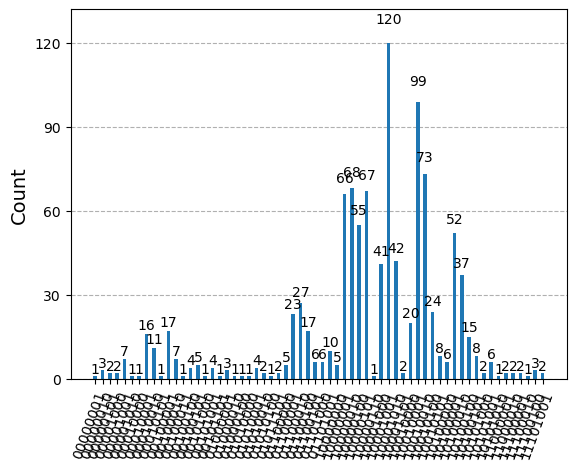

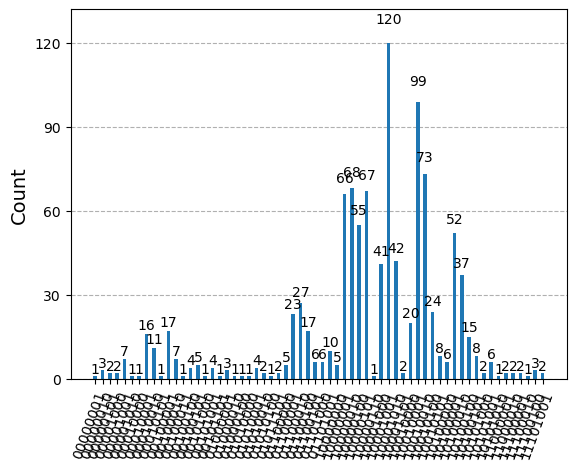

In [505]:
plot_histogram(result.get_counts())

#### Classical post-processing:

In [506]:
value = int(max(counts, key=counts.get), 2)
print(f"Measured value: {value}")

Measured value: 137


In [507]:
phase = value / 2**(2*n)
print(f"Estimated phase: {phase}")

Estimated phase: 0.53515625


In [508]:
if phase == 0:
    print("Phase is zero, try again")
else:
    r = round(1/phase)
    print(f"Estimated r: {r}")
    if r % 2 != 0 or pow(a, r, N) == 1:
        print("r is odd or trivial, try again")
    else:
        p = gcd(pow(a, r // 2, N) - 1, N)
        q = gcd(pow(a, r // 2, N) + 1, N)
        if p == 1 or q == N:
            print("Factors are trivial, try again")
        print(f"Factors: {p}, {q}")

Estimated r: 2
Factors: 3, 1
